# <center>Recurrent Neural Networks</center>
## <center>Inclass Project 3 - MA4144</center>

This project contains multiple tasks to be completed, some require written answers. Open a markdown cell below the respective question that require written answers and provide (type) your answers. Questions that required written answers are given in blue fonts. Almost all written questions are open ended, they do not have a correct or wrong answer. You are free to give your opinions, but please provide related answers within the context.

After finishing project run the entire notebook once and **save the notebook as a pdf** (File menu -> Save and Export Notebook As -> PDF). You are **required to upload both this ipynb file and the PDF on moodle**.

***

## Outline of the project

The aim of the project is to build a RNN model to suggest autocompletion of half typed words. You may have seen this in many day today applications; typing an email, a text message etc. For example, suppose you type in the four letter "univ", the application may suggest you to autocomplete it by "university".

![Autocomplete](https://d33v4339jhl8k0.cloudfront.net/docs/assets/5c12e83004286304a71d5b72/images/66d0cb106eb51e63b8f9fbc6/file-gBQe016VYt.gif)

We will train a RNN to suggest possible autocompletes given $3$ - $4$ starting letters. That is if we input a string "univ" hopefully we expect to see an output like "university", "universal" etc.

For this we will use a text file (wordlist.txt) containing 10,000 common English words (you'll find the file on the moodle link). The list of words will be the "**vocabulary**" for our model.

We will use the Python **torch library** to implement our autocomplete model. 

***


Use the below cell to use any include any imports

In [175]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import random
import time

## Section 1: Preparing the vocabulary

In [176]:
WORD_SIZE = 13

**Q1.** In the following cell provide code to load the text file (each word is in a newline), then extract the words (in lowercase) into a list.

For practical reasons of training the model we will only use words that are longer that $3$ letters and that have a maximum length of WORD_SIZE (this will be a constant we set at the beginning - you can change this and experiment with different WORD_SIZEs). As seen above it is set to $13$.

So out of the extracted list of words filter out those words that match our criteria on word length.

To train our model it is convenient to have words/strings of equal length. We will choose to convert every word to length of WORD_SIZE, by adding underscores to the end of the word if it is initially shorter than WORD_SIZE. For example, we will convert the word "university" (word length 10) into "university___" (wordlength 13). In your code include this conversion as well.

Store the processed WORD_SIZE lengthed strings in a list called vocab.

In [177]:
vocab = []

# Read the text file
with open('wordlist.txt', 'r') as file:
    # Extract words, convert to lowercase, and store in a list
    words = [line.strip().lower() for line in file]

# Filter words: length > 3 and length <= WORD_SIZE
filtered_words = [word for word in words if len(word) > 3 and len(word) <= WORD_SIZE]

# Pad words to WORD_SIZE with underscores
for word in filtered_words:
    padded_word = word + '_' * (WORD_SIZE - len(word))
    vocab.append(padded_word)

# Print some stats for verification
print(f"Total words in vocab: {len(vocab)}")
print(f"Sample words: {vocab[:5]}")

Total words in vocab: 8847
Sample words: ['aaron________', 'abandoned____', 'aberdeen_____', 'abilities____', 'ability______']


<font color='blue'>In the above explanation it was mentioned "for practical reasons of training the model we will only use words that are longer that $3$ letters and that have a certain maximum length". In your opinion what could be those practical? Will hit help to build a better model?</font>

Filtering words to those longer than 3 letters and capped at WORD_SIZE=13, with padding to a fixed length, is practical for training an RNN autocomplete model. It focuses on words needing autocompletion (e.g., "university" vs. "cat"), provides richer sequences for learning, and reduces noise from short words. The length cap limits memory and computation, covers most common words, and ensures uniform sequence lengths for easier training. Padding simplifies model design and signals word endings. These choices improve efficiency and task alignment, likely leading to better generalization, though they exclude some words and introduce artificial tokens. The model's quality also hinges on architecture and tuning, and experimenting with WORD_SIZE or including short words could further validate these benefits.

**Q2** To input words into the model, we will need to convert each letter/character into a number. as we have seen above, the only characters in our list vocab will be the underscore and lowercase english letters. so we will convert these $27$ characters into numbers as follows: underscore -> $0$, 'a' -> $1$, 'b' -> $2$, $\cdots$, 'z' -> $26$. In the following cell,

(i) Implement a method called char_to_num, that takes in a valid character and outputs its numerical assignment.

(ii) Implement a method called num_to_char, that takes in a valid number from $0$ to $26$ and outputs the corresponding character.

(iii) Implement a method called word_to_numlist, that takes in a word from our vocabulary and outputs a (torch) tensor of numbers that corresponds to each character in the word in that order. For example: the word "united_______" will be converted to tensor([21, 14,  9, 20,  5,  4,  0,  0,  0,  0,  0,  0,  0]). You are encouraged to use your char_to_num method for this.

(iv) Implement a method called numlist_to_word, that does the opposite of the above described word_to_numlist, given a tensor of numbers from $0$ to $26$, outputs the corresponding word. You are encouraged to use your  num_to_char method for this.

Note: As mentioned since we are using the torch library we will be using tensors instead of the usual python lists or numpy arrays. Tensors are the list equivalent in torch. Torch models only accept tensors as input and they output tensors.

In [178]:
def char_to_num(char):
    #TODO
    charset = '_abcdefghijklmnopqrstuvwxyz'
    num = charset.index(char)
    return(num)

def num_to_char(num):
    #TODO
    charset = '_abcdefghijklmnopqrstuvwxyz'
    char = charset[num]
    return(char)

def word_to_numlist(word):
    #TODO
    numlist = [char_to_num(char) for char in word]
    numlist = torch.tensor(numlist, dtype=torch.long)
    return(numlist)

def numlist_to_word(numlist):
    #TODO
    num_list = numlist.tolist()
    word = ''.join(num_to_char(num) for num in num_list)
    return(word)

<font color='blue'>We convert letter into just numbers based on their aphabetical order, I claim that it is a very bad way to encode data such as letters to be fed into learning models, please write your explanation to or against my claim. If you are searching for reasons, the keyword 'categorical data' may be useful. Although the letters in our case are not treated as categorical data, the same reasons as for categorical data is applicable. Even if my claim is valid, at the end it won't matter due to something called "embedding layers" that we will use in our model. What is an embedding layer? What is it's purpose? Explain.</font>

Critique of Alphabetical Encoding: Encoding letters as numbers (e.g., a → 1, z → 26) is simple but problematic because it imposes artificial ordinal relationships on categorical data (letters), implying false proximity (e.g., a "closer" to b than z). This lacks semantic meaning and may hinder learning. However, this won’t matter due to embedding layers, which map these numbers to dense, learnable vectors that capture meaningful relationships during training.

Embedding Layer: A neural network layer that converts discrete indices into dense vectors (e.g., 50–100 dimensions).

Purpose: To learn semantic representations, reduce dimensionality, and enable generalization by transforming crude encodings into task-specific, meaningful features.

## Section 2: Implementing the Autocomplete model

We will implement a RNN LSTM model. The [video tutorial](https://www.youtube.com/watch?v=tL5puCeDr-o) will be useful. Our model will be only one hidden layer, but feel free to sophisticate with more layers after the project for your own experiments.

Our model will contain all the training and prediction methods as single package in a class (autocompleteModel) we will define and implement below.

In [179]:
LEARNING_RATE = 0.005

In [180]:
class autocompleteModel(nn.Module):
    def __init__(self, alphabet_size, embed_dim, hidden_size, num_layers):
        super().__init__()
        self.alphabet_size = alphabet_size
        self.embed_dim = embed_dim
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(alphabet_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, alphabet_size)

    def forward(self, sequence, hidden_state, cell_state):
        embedded = self.embedding(sequence.unsqueeze(0))  # [1, seq_len, embed_dim]
        lstm_out, (hidden_state, cell_state) = self.lstm(embedded, (hidden_state, cell_state))
        output = self.fc(lstm_out.squeeze(0))  # [seq_len, alphabet_size]
        return output, hidden_state, cell_state

    def initial_state(self, batch_size=1):
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        return h0, c0

    def trainModel(self, vocab, epochs=5, batch_size=100, learning_rate=0.005, device='cpu'):
        self.train()
        self.to(device)
        optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        criterion = nn.CrossEntropyLoss()
        loss_log = []

        for e in range(epochs):
            random.shuffle(vocab)
            num_iter = len(vocab) // batch_size + (1 if len(vocab) % batch_size != 0 else 0)
            total_loss = 0

            for i in range(num_iter):
                start_time = time.time()
                start_idx = i * batch_size
                end_idx = min(start_idx + batch_size, len(vocab))
                vocab_batch = vocab[start_idx:end_idx]
                optimizer.zero_grad()
                batch_loss = 0

                for word in vocab_batch:
                    h0, c0 = self.initial_state()
                    h0, c0 = h0.to(device), c0.to(device)
                    word_tensor = word_to_numlist(word).to(device)
                    input_seq = word_tensor[:-1]  # [WORD_SIZE-1]
                    target_seq = word_tensor[1:]  # [WORD_SIZE-1]

                    output, _, _ = self.forward(input_seq, h0, c0)  # [WORD_SIZE-1, alphabet_size]
                    loss = criterion(output, target_seq)
                    batch_loss += loss

                batch_loss = batch_loss / len(vocab_batch)
                batch_loss.backward()
                optimizer.step()
                total_loss += batch_loss.item()
                loss_log.append(batch_loss.item())

                # print(f"Iteration {i+1}/{num_iter}, Time: {time.time() - start_time:.2f}s")

            avg_loss = total_loss / num_iter
            print(f"Epoch {e+1}/{epochs}, Average Loss: {avg_loss:.4f}")

        return loss_log

    def autocomplete(self, sample, device='cpu'):
        self.eval()
        self.to(device)
        completed_list = []

        for literal in sample:
            h0, c0 = self.initial_state()
            h0, c0 = h0.to(device), c0.to(device)
            input_tensor = word_to_numlist(literal + '_' * (WORD_SIZE - len(literal))).to(device)
            predicted_word = literal

            for c in range(len(literal)):
                output, h0, c0 = self.forward(input_tensor[c:c+1], h0, c0)

            for _ in range(WORD_SIZE - len(literal)):
                softmax = torch.softmax(output[-1], dim=0)
                next_char_idx = torch.multinomial(softmax, 1).item()
                predicted_word += num_to_char(next_char_idx)
                output, h0, c0 = self.forward(torch.tensor([next_char_idx], dtype=torch.long, device=device), h0, c0)

            predicted_word = predicted_word.rstrip('_')
            completed_list.append(predicted_word)

        return completed_list

## Section 3: Using and evaluating the model

(i) Initialize and train autocompleteModels using different embedding dimensions and hidden layer sizes. Use different learning rates, epochs, batch sizes. Train the best model you can.

(ii) Evaluate it on different samples of partially filled in words to test your model. Eg: ["univ", "math", "neur", "engin"] etc.

(iii) Set your best model, to the variable best_model. This model will be tested against random inputs (3-4 starting strings of common English words). **This will be the main contributor for your score in this project**.


Training model with config: {'embed_dim': 30, 'hidden_size': 64, 'num_layers': 1, 'epochs': 5, 'batch_size': 100, 'learning_rate': 0.005}
Epoch 1/5, Average Loss: 1.6234
Epoch 2/5, Average Loss: 1.3013
Epoch 3/5, Average Loss: 1.2198
Epoch 4/5, Average Loss: 1.1707
Epoch 5/5, Average Loss: 1.1373

Total training time: 30.39 seconds


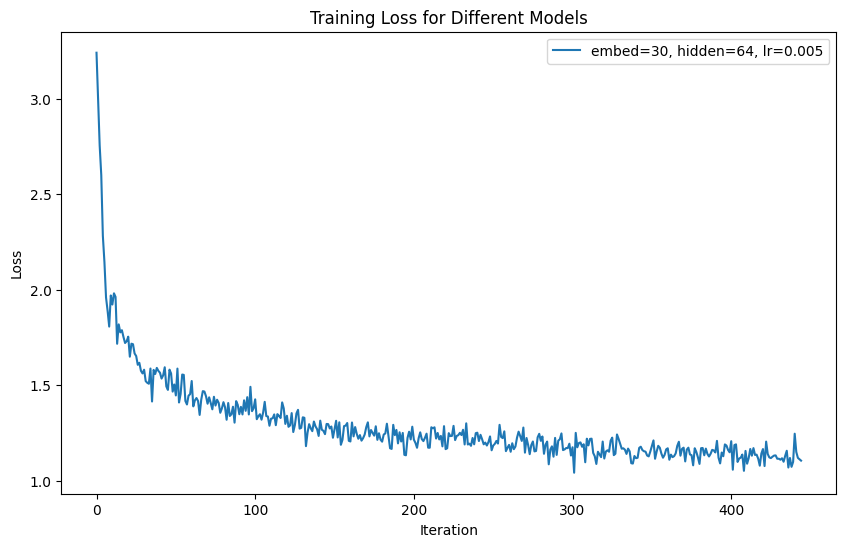


Evaluating model 1 with config: {'embed_dim': 30, 'hidden_size': 64, 'num_layers': 1, 'epochs': 5, 'batch_size': 100, 'learning_rate': 0.005}
Input: univ, Predicted: unived
Input: math, Predicted: mathome
Input: neur, Predicted: neurd
Input: engin, Predicted: enginers

Best model selected: Config {'embed_dim': 30, 'hidden_size': 64, 'num_layers': 1, 'epochs': 5, 'batch_size': 100, 'learning_rate': 0.005} with final loss 1.1053

Best model predictions on test samples:
Input: univ, Predicted: univity
Input: math, Predicted: math
Input: neur, Predicted: neurnia
Input: engin, Predicted: enginapine


In [181]:
hyperparameter_configs = [
    {"embed_dim": 30, "hidden_size": 64, "num_layers": 1, "epochs": 5, "batch_size": 100, "learning_rate": 0.005}
]

models = []
loss_logs = []

start_time = time.time()  # Start timing

for config in hyperparameter_configs:
    print(f"\nTraining model with config: {config}")
    model = autocompleteModel(alphabet_size=27, 
                            embed_dim=config["embed_dim"], 
                            hidden_size=config["hidden_size"], 
                            num_layers=config["num_layers"])
    
    loss_log = model.trainModel(vocab, 
                               epochs=config["epochs"], 
                               batch_size=config["batch_size"], 
                               learning_rate=config["learning_rate"]
                               )
    
    models.append(model)
    loss_logs.append(loss_log)

end_time = time.time()  # End timing
print(f"\nTotal training time: {end_time - start_time:.2f} seconds")

plt.figure(figsize=(10, 6))
for i, config in enumerate(hyperparameter_configs):
    plt.plot(loss_logs[i], label=f"embed={config['embed_dim']}, hidden={config['hidden_size']}, lr={config['learning_rate']}")
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss for Different Models')
plt.legend()
plt.show()

test_samples = ["univ", "math", "neur", "engin"]
for i, (model, config) in enumerate(zip(models, hyperparameter_configs)):
    print(f"\nEvaluating model {i+1} with config: {config}")
    predictions = model.autocomplete(test_samples)
    for sample, pred in zip(test_samples, predictions):
        print(f"Input: {sample}, Predicted: {pred}")

final_losses = [log[-1] for log in loss_logs]
best_model_idx = np.argmin(final_losses)
best_model = models[best_model_idx]
print(f"\nBest model selected: Config {hyperparameter_configs[best_model_idx]} with final loss {final_losses[best_model_idx]:.4f}")

# Test best model on additional samples
print("\nBest model predictions on test samples:")
predictions = best_model.autocomplete(test_samples)
for sample, pred in zip(test_samples, predictions):
    print(f"Input: {sample}, Predicted: {pred}")


In [182]:
try:
    import requests
    import io
    def load_online_model():
      weights_url = "https://github.com/Garthigan/AutoCompleteRNN/raw/main/best_autocomplete_model.pt"
      response = requests.get(weights_url, timeout=10)
      response.raise_for_status()  
      model_bytes = io.BytesIO(response.content)
    
      model = autocompleteModel(
          alphabet_size=27,
          embed_dim=100,
          hidden_size=256,
          num_layers=1
        )
      model.load_state_dict(torch.load(model_bytes))
      model.eval()
      return model
    best_model = load_online_model()
    print("Model loaded from online source.")
except Exception as e:
    best_model = models[best_model_idx]